# Financial Cliff Walking Problem

Consider an over simplified model of household finance. Let $S_t$ be the amount of money a household has at time $t$. We assume for simplicity that $S_t$ can only take values in a discrete set $\large{\{S^{(i)}\}_{i=0}^{N-1}}$. The account has to be maintained for $T$ time steps, after which it should be closed. So $T$ is the planning horizon. The zero-level $S^{(0)}=0$ is a bankruptcy level - it has to be avoided as reaching it means inability to pay on household liabilities. At each step, the agent can deposit to the account $S^{(i)} \rightarrow S^{(i+1)}$ (action $a_+$), withdraw from the account $S^{(i)} \rightarrow S^{(i-1)}$, (action $a_-$), or keep the same amount $S^{(i)} \rightarrow S^{(i)}$, (action $a_0$). The initial amount in the account is zero. For any step before the final step $T$, if the agent moves to the zero level  $S_0 = 0$, it gets a negative reward of $-100$, and the episode terminates. Otherwise, it continues for all $T$ steps. Any action not leading to the zero level gets a negative reward of $-1$. At the terminal time, if the final state is $S_T>0$, the reward is $-10$, but if the account goes back to zero exactly at time $T$, i.e. $S_T=0$, then the last action gets a positive reward of $+10$. The learning task is to maximize the totwal reward over $T$ time steps. The RL agent has to learn the optimal depository policy online by trying different actions during a training episode. Note that while this is a time-dependent problem, we can map it on to a stationary problem with an episodic task and a target state, such as the original cliff walking problem in Sutton-Barto.

<img src="The-cliff-walking-task.jpg">

### Import some libraries

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

#Tqdm is used to show nice progress bars while the RL agent is going through its learning process.
from tqdm import tqdm 

#To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

## Set Up

We assume $N=4$ values of possible funds in the account, and assume $T=12$ time steps. All combinations of state and time can then be represented as a two-dimensional grid of size $N\times T = 4\times 12$. A time dependent action value function $Q_t\left( s_t, a_t\right)$ with three possible actions, $a_t = \left\{a_+, a_-, a_0\right\}$, can then be stored as a rank three tensor of dimension $4\times 12 \times 3$.

#### Setting up some global parameters

In [2]:
# N - World height
# T - World width
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

In [3]:
# Probability for exploration - epsilon
EPSILON = 0.99
# Step size
ALPHA = 0.01
# Gamma - discount factor - for Q-Learning, Sarsa and Expected Sarsa
GAMMA = 1

In [4]:
# Actions - ACTION_UP is a+ (adding a deposit), ACTION_DOWN is a-(redeeming a deposit) and 
# ACTION_ZERO is a0 (leaving the account as it is).
ACTION_UP = 1
ACTION_DOWN = 2
ACTION_ZERO = 0
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_ZERO]

In [5]:
# Initial and Goal states
START = [0, 0]
GOAL = [0, WORLD_WIDTH-1]

#### Setting up the environment

In [26]:
# Step function that describes how the next state is obtained from the current state and the action 
# taken. The function returns the next state and the reward obtained.
# p_sp: probability of stochastic payment
def step(state, action, p_sp=None):
    i, j = state

    if p_sp and (j == 5 or j == 6):  # step 5 or 6
        # stochastic payments that result in decrease in balances by one with probability p.
        # The stochasticity is represented by probability p 
        if np.random.binomial(1, p_sp) == 1:
            # payment with cost 1 due, decrease balances represented by i
            # print(f"stochastic payment occurred, decrease balance from {i} to {i-1}")
            i -= 1

    if action == ACTION_UP:
        next_state = [min(i + 1, WORLD_HEIGHT-1), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [max(i - 1, 0), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_ZERO:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False
    
    # The reward is -1 for actions ACTION_UP and ACTION_DOWN. This is done to keep transactions to a minimum.
    reward = -1
    
    # ACTION_ZERO gets a zero reward since we want to minimize the number of transactions
    if action == ACTION_ZERO:
        reward = 0
    
    # Exceptions are 
    # i) If bankruptcy happens before WORLD_WIDTH time steps
    # ii) No deposit at initial state
    # iii) Redemption at initial state!
    # iv) Any action carried out from a bankrupt state
    if ((action == ACTION_DOWN and i == 1 and 1 <= j < 10) or (
        action == ACTION_ZERO and state == START) or (
        action == ACTION_DOWN and state == START )) or (
        i == 0 and 1 <= j <= 10):    
            reward = -100
        
    # Next exception is when we get to the final time step.
    if (next_state[1] == WORLD_WIDTH - 1): 
        if (next_state[0] == 0): # Action resulted in ending with zero balance in final time step
            reward = 10
        else:
            reward = -10   
        
    return next_state, reward

In [17]:
# Check some state, action pairs and the associated reward
print(step([0,0], ACTION_UP))
print(step([0,0], ACTION_DOWN))
print(step([1,1], ACTION_UP))
print(step([1,1], ACTION_DOWN))
print(step([1,0], ACTION_DOWN)) 
print(step([1,0], ACTION_UP)) 
print(step([1,0], ACTION_ZERO)) 

([1, 1], -1)
([0, 1], -100)
([2, 2], -1)
([0, 2], -100)
([0, 1], -1)
([2, 1], -1)
([1, 1], 0)


#### Set up the agent's action

In [18]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # This policy often chooses the action that gives maximum action value, but there is small probability eps
    # to chose random action
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
        # print(f"choosing random action: {action}")
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # From bankrupt state there is no meaningful action, so we will assign 'Z' by convention.
    if state[0] == 0 and state[1] > 0:
        action = ACTION_ZERO
    return action
    

In [19]:
#Check soeme of the actions
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
print(choose_action([0, 2], q_value, EPSILON))
print(choose_action([1, 7], q_value, EPSILON))
# print(q_value)

0
2


#### Set up the learning algorithms

##### Sarsa and Expected Sarsa

In [20]:
# An episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON, p_sp=None):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    # print('In sarsa: action = ', action)
    while (state[1] != WORLD_WIDTH-1) and not(1 <= state[1] <= 10 and state[0]==0): #why not start with one
        next_state, reward = step(state, action, p_sp=p_sp)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]  #  target -> Q(S_t+1, A_t+1)
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
                    
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

##### Q-learning

In [21]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA, eps=EPSILON, p_sp=None):
    state = START
    rewards = 0.0
    while state[1] != WORLD_WIDTH-1 and not(1 <= state[1] <= 10 and state[0]==0):
        action = choose_action(state, q_value, eps)
        next_state, reward = step(state, action, p_sp=p_sp)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards


##### Printing output of the learned policy

In [22]:
# Print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(WORLD_HEIGHT-1, -1, -1):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            
            # Action in bankrupt state has been set as Z
            if i == 0 and j > 0 and j < WORLD_WIDTH-1:
                optimal_policy[-1].append('Z')
            elif bestAction == ACTION_UP:
                # When i = WORLDHEIGHT - 1, U and Z are identical, so we will use Z
                if i == WORLD_HEIGHT-1:
                    optimal_policy[-1].append('Z')
                else:
                    optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_ZERO:
                optimal_policy[-1].append('Z')
            
            
    for row in optimal_policy:
        print(row)

#### Set up the epsilon decay

- We will use the decreasing epsison when increasing episode
- The epsilon should strives to zero in order for the q-value function to converge to the optimal q-value function in SARSA algorithm
- The following figure demonstrates the exponetial decay we are going to use

Text(0, 0.5, 'Epsilone')

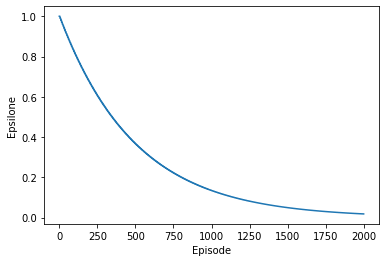

In [23]:
plt.plot([ EPSILON**(i//5) for i in range(2000)])
plt.xlabel('Episode')
plt.ylabel('Epsilone')

### Running Sarsa and Q-learning 

In [28]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4(p_stochastic_payment=None):
    if p_stochastic_payment :
        assert p_stochastic_payment >= 0 and p_stochastic_payment <= 1
    # episodes of each run
    episodes = 2000
    EPOCH = 5

    # perform 100 independent runs
    runs = 50  #  100

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    # for r in tqdm(range(runs)):
    for r in range(runs):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        for i in range(0, episodes):
            eps = EPSILON**(i//EPOCH)#EPSILON*((1-EPSILON)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa,eps=eps, p_sp=p_stochastic_payment)
            rewards_q_learning[i] += q_learning(q_q_learning, eps=eps, p_sp=p_stochastic_payment)

    # averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 11])
    plt.legend()
#     Uncomment to save the figures
#     plt.savefig('../images/figure_6_4.png')
#     plt.close()

    # display optimal policy
    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)
    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)
    return q_sarsa, q_q_learning

Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'U', 'U', 'U', 'U', 'Z', 'U', 'U', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'U', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']


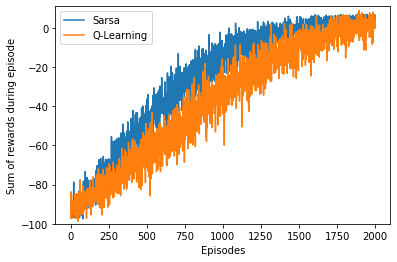

In [27]:
# no wind, no stochastic payments
figure_6_4()
plt.show()

### Running Sarsa, Expected Sarsa and Q-learning to compare their asymptotic behavior

In [33]:
# With 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even for 1,000 episodes and 10 runs, the curves looks still good.
def figure_6_6():
    step_sizes = np.arange(0.001, 0.25, 0.04)
    episodes = 4000
    runs = 20

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(step_sizes)))
    for run in range(runs):
        # for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
        for ind, step_size in list(zip(range(0, len(step_sizes)), step_sizes)):
            q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
            q_expected_sarsa = np.copy(q_sarsa)
            q_q_learning = np.copy(q_sarsa)
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
                q_learning_reward = q_learning(q_q_learning, step_size=step_size)
                performace[ASY_SARSA, ind] += sarsa_reward
                performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[ASY_QLEARNING, ind] += q_learning_reward

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsa_reward
                    performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                    performace[INT_QLEARNING, ind] += q_learning_reward

    performace[:3, :] /= episodes * runs
    performace[3:, :] /= 100 * runs
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

    for method, label in zip(methods, labels):
        plt.plot(step_sizes, performace[method, :], label=label)
        if method == 2:
            break  # only show asymptotic
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.title(f"For each alpha, runs: {runs} episodes: {episodes}")
    plt.legend()
#     Uncomment to save the figures
#     plt.savefig('../images/figure_6_6.png')
#     plt.close()

#### Start the runs

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.69s/it]


Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']


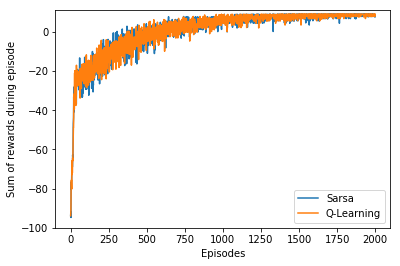

In [16]:
#Epsilon = 0.1; EPOCH = 40; eps = EPSILON*((1-EPSILON)**(i//EPOCH))
figure_6_4()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.90s/it]


Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'U', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']


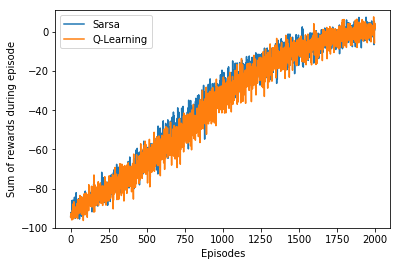

In [23]:
#Epsilon = 0.99; EPOCH = 5; eps = EPSILON**(i//EPOCH))
figure_6_4()
plt.show()

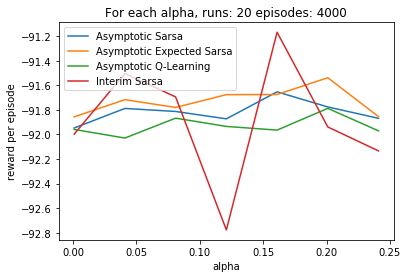

In [34]:
figure_6_6()
plt.show()

### Additional problems:

Problems setting: 
- Introduce the "wind" in Financial Cliff: during steps 5 and 6 from the start there is stochastic payments that result in decrease in balances by one. The stochasticity is represented by probability $p$. The payments are  independent from each other.

Task:
- Adjust the code for the step function according to the problem setting and rerun the results for both SARSA and Q-Learning.
- How the optimal path looks like in case of presence of obligatory stochastic payments that appear at step 5 and 6 indepedently with probability p=1.0?
- Make the probability of payments small enough (p=0.000001) and compare the optimal paths. Check your intuition before running the code: how the optimal paths should be different in case of Low and High probability of payments?

### 1)Adjust the code for the step function according to the problem setting and rerun the results for both SARSA and Q-Learning.
Rerunning the results with p={0.1, 0.4, 0.6}..

Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'U', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'U', 'Z', 'U', 'U', 'Z', 'Z', 'U', 'U', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'D', 'Z']
['Z', 'Z', 'Z', 'U', 'U', 'Z', 'U', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']


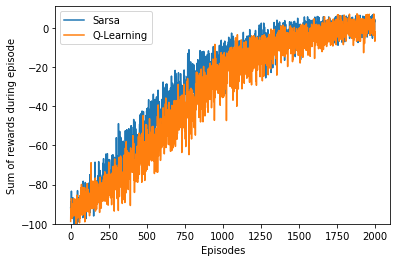

In [35]:
# 10% chance of stochastic payments at step 5 and 6
figure_6_4(p_stochastic_payment=0.1)
plt.show()

In [ ]:
# 40% chance of stochastic payments at step 5 and 6
figure_6_4(p_stochastic_payment=0.4)
plt.show()

In [ ]:
# 60% chance of stochastic payments at step 5 and 6
figure_6_4(p_stochastic_payment=0.6)
plt.show()

### 2) How the optimal path looks like in case of presence of obligatory stochastic payments that appear at step 5 and 6 indepedently with probability p=1.0?
Run figure_6_4() again with P_PAYMENT = 1.0

In [ ]:
# obligatory payments at step 5 and 6
figure_6_4(p_stochastic_payment=1.0)
plt.show()

### 3) Make the probability of payments small enough (p=0.000001) and compare the optimal paths. Check your intuition before running the code: how the optimal paths should be different in case of Low and High probability of payments?
My intuition as to how the optimal paths should differ between low and high probability of payments: 
- for both TD control methods the balance should be as low as possible except for steps 5 and 6, i.e. at step 4, accounting for 2 payments, i.e. at least with balance 2 or perhaps 3. For Q-learning perhaps 2 as it learns the optimal path w/o paymentsand for Sarsa 3, being more on the safe path side.

In [ ]:
# obligatory payments at step 5 and 6
figure_6_4(p_stochastic_payment=0.000001)
plt.show()